In [6]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [9]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [10]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [11]:
with open(os.path.join(working, 'stats_ready_x'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_ready_x'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [12]:
print(stats_ready['hyperparams'])

[2.375, 2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5, 6.0]


In [9]:
#multi_index = []
#multi_index.append([0, 2, 3, 5, 7, 10, 12, 15])
#multi_index.append([0, 2, 4, 6, 8, 10, 12, 14])
#multi_index.append([0, 2, 4, 6, 8, 11, 13, 15])
#multi_index.append([1, 2, 3, 5, 7, 10, 12, 14])
#multi_index.append([1, 2, 4, 6, 8, 11, 13, 15])
#multi_index.append([1, 2, 4, 6, 9, 11, 13, 15])
#multi_index.append([1, 3, 5, 7, 9, 11, 13, 15])

In [13]:
#stats_opts = []
#for index in multi_index:
#    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
#    print(np.array(stats_ready['hyperparams'])[index])
#    stats_opts.append(select_nodes(stats_ready, index))

In [14]:
stats_opts = [stats_ready]

In [15]:
#with open(os.path.join(working, "stats_multi.pickle"), 'wb') as fo:
#    pickle.dump(stats_opts, fo)

In [16]:
#with open(os.path.join(working, "target_multi.pickle"), 'wb') as fo:
#    pickle.dump(targ_ready, fo)

In [17]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [18]:
#with open(os.path.join(working, 'stats_multi.pickle'), 'rb') as fi:
#    stats_opts = pickle.load(fi)
#
#with open(os.path.join(working, 'target_multi.pickle'), 'rb') as fi:
#    targ_ready = pickle.load(fi)   

In [19]:
it = 0 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [20]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=2):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
                 
    best_params = sorted(optimal_parameters)[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [22]:
multi_pars = [[-0.684229349, 0.000152487644, 0.0, -65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974, 0.0]]
#multi_pars.append(pars_in)
for _ in range(4):
    pars = np.array(multi_pars[0])
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

[-6.37957119e-01  5.12653658e-02 -2.97730917e-02 -6.56865213e+01
  2.28793828e+01 -3.44929675e+00  3.37209320e+00 -8.46482332e-01
 -1.19789083e+00  1.16654851e+00 -3.25522122e-01 -4.34821322e-02]
[-7.37480258e-01 -3.14897552e-03  1.04032278e-01 -6.57870810e+01
  2.30525796e+01 -3.47831901e+00  3.34136401e+00 -9.20155289e-01
 -1.37830362e+00  1.28784081e+00 -3.38990490e-01 -3.42336820e-02]
[-7.52856848e-01 -6.90499786e-02  1.15180275e-01 -6.57214915e+01
  2.30118962e+01 -3.49689000e+00  3.51089918e+00 -9.66350789e-01
 -1.35655224e+00  1.17907404e+00 -3.92005305e-01  2.95565839e-02]
[-6.87795020e-01 -1.01050029e-01  1.04174121e-01 -6.57854383e+01
  2.29864546e+01 -3.52363733e+00  3.54921366e+00 -7.28223853e-01
 -1.41403545e+00  1.26023886e+00 -2.20001363e-01  6.21123018e-02]


In [23]:
for ieam in range(7, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, multi_pars)
        multi_pars = [p[1] for p in best_pars]

ieam: 7
0  sd2: ini 6.179839470143365e-05sd2: final 5.878638484138787e-05
1  sd2: ini 28.978243373337797sd2: final 0.0006495510356270202
2  sd2: ini 21.0496557022991sd2: final 0.00030553947586211714
3  sd2: ini 31.44634074852179

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  eee = np.exp(-uuu)


sd2: final 7.324859149808127e-05
4  sd2: ini 32.28480600376304sd2: final 7.283481656057265e-05
Best params: [(5.878638484138787e-05, array([-7.08184677e-01,  1.51852407e-04, -1.31320616e-01, -6.96351431e+01,
        2.31559691e+01, -3.47540518e+00,  3.45591332e+00, -8.98685105e-01,
       -1.34956764e+00,  1.25149700e+00, -3.51508937e-01,  1.23177213e-03])), (7.283481656057265e-05, array([-8.65377631e-01,  1.13168130e-04,  8.96703738e-02, -8.52365713e+01,
        2.58115680e+01, -3.30087886e+00,  3.38784892e+00, -1.07199896e+00,
       -1.13889505e+00,  1.21145992e+00, -3.76446633e-01,  2.46748571e-02]))]
0  sd2: ini 5.878638484138787e-05sd2: final 5.520005704303636e-05
1  sd2: ini 7.283481656057265e-05sd2: final 6.233046667451805e-05
Best params: [(5.520005704303636e-05, array([-7.12429640e-01,  1.44386706e-04, -1.54012957e+02, -6.68117685e+01,
        2.33057262e+01, -3.44645015e+00,  3.45434931e+00, -8.80457971e-01,
       -1.35973136e+00,  1.25322674e+00, -3.52025752e-01,  1.638557

0  sd2: ini 0.00012623075659499983sd2: final 0.00011152918642253047
1  sd2: ini 0.00029037980930256453sd2: final 0.0001103320914631527
Best params: [(0.0001103320914631527, array([-4.53883021e-01,  1.10037320e-05, -3.10296867e+02, -3.96311802e+01,
        2.34487341e+01, -2.53968794e+00,  2.35671979e+00, -3.74544072e-01,
       -8.85845690e-01,  6.50370383e-01, -3.71463893e-01,  1.12165461e-01])), (0.00011152918642253047, array([-1.78793868e-01,  2.18053721e-05, -2.54231499e+02, -4.98445734e+01,
        2.06106985e+01, -2.79218097e+00,  2.40755860e+00,  4.63730579e-01,
       -2.10151851e+00,  1.27749130e+00, -4.38173206e-01,  2.45265817e-02]))]
0  sd2: ini 0.0001103320914631527sd2: final 0.00011014587380836677
1  sd2: ini 0.00011152918642253047sd2: final 0.0001107494600514898
Best params: [(0.00011014587380836677, array([-4.55154269e-01,  1.11021182e-05, -2.96276986e+02, -4.01664005e+01,
        2.34458412e+01, -2.53641063e+00,  2.34405287e+00, -3.52924749e-01,
       -9.06338705e-01,

In [21]:
multi_pars

[array([-3.99852964e-01,  5.19903525e-05, -4.35853845e+01,  1.94974779e+01,
        -3.41125084e+00,  3.29583141e+00, -6.74970661e-01, -1.24161605e+00,
         9.55571732e-01, -2.67603787e-01]),
 array([-3.08115841e-01,  6.08583920e-05, -3.55322048e+01,  1.74741498e+01,
        -3.45456667e+00,  3.55864207e+00, -1.02844413e+00, -1.10262198e+00,
         1.06957764e+00, -3.33945049e-01])]

In [24]:
optimal_parameters = [(5.349796369598188e-05, [-7.30457241e-01,  1.37768909e-04, -1.93189371e+02, -7.26701281e+01,
        2.42802710e+01, -3.46529902e+00,  3.27059189e+00, -4.85489870e-01,
       -1.63989584e+00,  1.25380560e+00, -3.15637416e-01, -8.52044655e-03]), (5.4780577635088105e-05, [-7.38180452e-01,  1.37714172e-04, -1.64481925e+02, -6.85468172e+01,
        2.37463589e+01, -3.43169033e+00,  3.41214610e+00, -8.31575223e-01,
       -1.37767634e+00,  1.24176551e+00, -3.45678532e-01,  2.46117714e-03])]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1139.0570269879665, -906.9688057613918, -1127.26307239685, -1136.3587484963377, -1136.6533416843513]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 5.349796369598188e-05
1 5.4780577635088105e-05


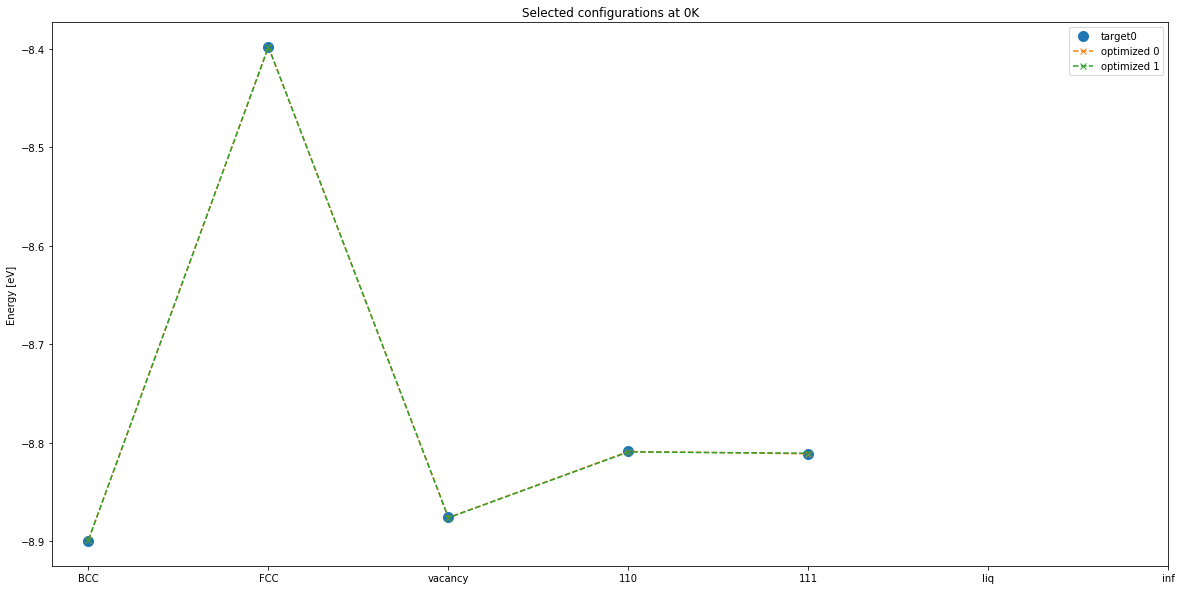

In [25]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

13
Targ: [-271.8047221070888, -837.1711089986524, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471663, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713144, -517.7429994565125, -443.4032853774631, -378.657941519064]
Model: [-272.34462971952576, -836.4444989893747, -1079.3553972428986, -1139.0570269879665, -1106.2471229213083, -1009.9074695747115, -903.8242042212149, -802.7605879635, -701.8854402049313, -603.0525351617994, -514.2205107742186, -442.1885208917365, -380.3105089134008]
[0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625
 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625]
0 5.349796369598188e-05
1 5.4780577635088105e-05


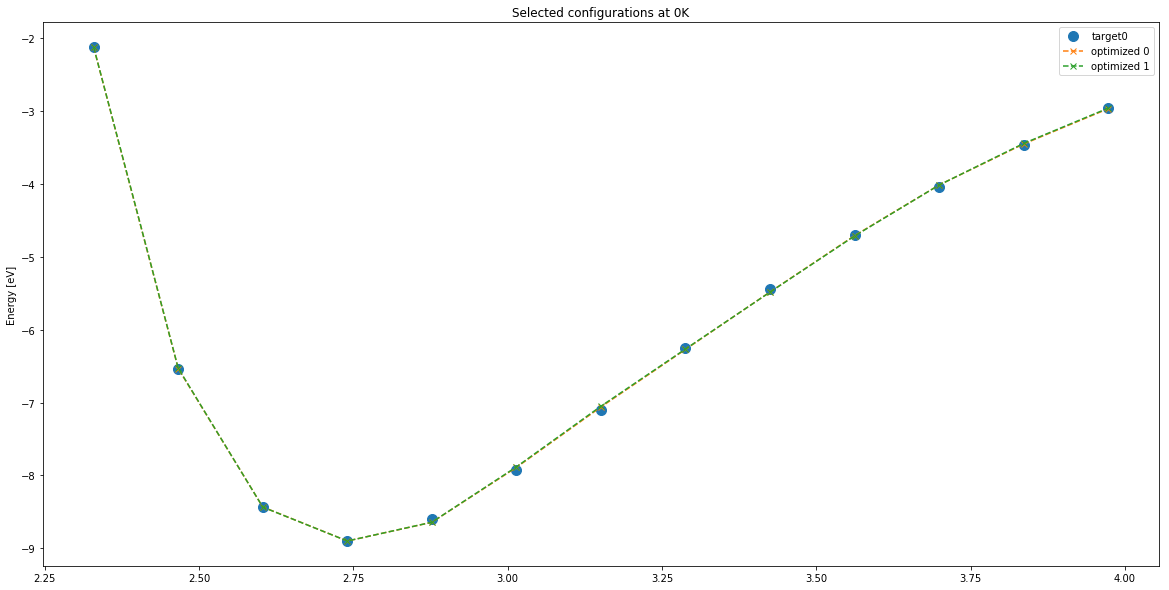

In [26]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 5.349796369598188e-05
1 5.4780577635088105e-05


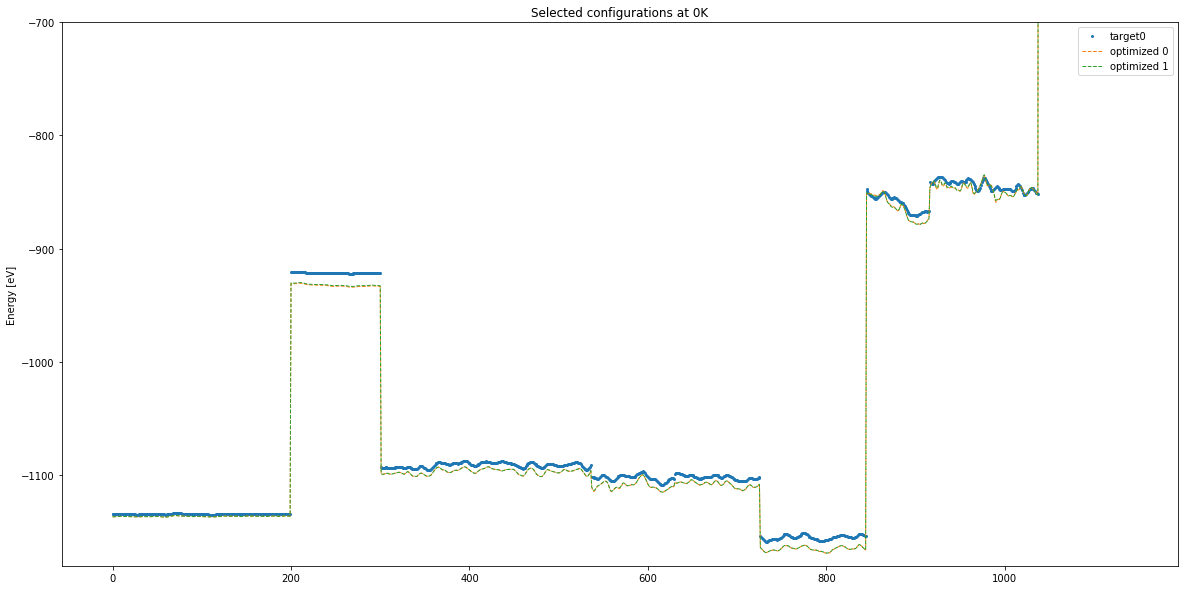

In [28]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
#plt.ylim(-1138,-1132)
#plt.ylim(-1000,-900)

plt.legend()

In [32]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 2.59409147888659e-05 
 [-0.684229349, 0.000152487644, -65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]
1 2.7011955577216733e-05 
 [-0.699918428, 0.000147393678, -60.3178636, 22.4303464, -3.52696503, 3.61710456, -1.18289073, -1.09946985, 1.18593759, -0.339115303]


In [126]:
stats_opt['hyperparams']

[2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75]

In [33]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [34]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[0]]

In [35]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [36]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [37]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
  'mb_node': 6,
  'params': [(2.59409147888659e-05,
    [-0.684229349,
     0.000152487644,
     -65.6958142,
     23.0194161,
     -3.48639263,
     3.45615281,
     -0.88808358,
     -1.34315802,
     1.24532843,
     -0.351200974])]}]

In [38]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [39]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [40]:
optimal_list[-1]['params'][0][1]

[-0.684229349,
 0.000152487644,
 -65.6958142,
 23.0194161,
 -3.48639263,
 3.45615281,
 -0.88808358,
 -1.34315802,
 1.24532843,
 -0.351200974]

In [41]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [42]:
pair_y, many_y, V_x_r, rho_x_r

([-65.6958142,
  23.0194161,
  -3.48639263,
  3.45615281,
  -0.88808358,
  -1.34315802,
  1.24532843,
  -0.351200974],
 [-0.684229349, 0.0, 0.000152487644],
 [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
 [5.0])

In [43]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

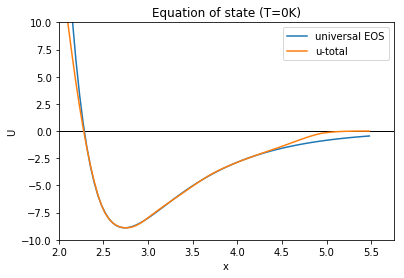

In [44]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel(r'U')

In [39]:
rho_a = [1.0]
rho_r = [stats_opt['hyperparams'][-1]]

pair_a = pars_in1[2:]
pair_r = stats_opt['hyperparams']

many_a = [pars_in[0], 0.0, pars_in[1]]

In [40]:
# Ranges of densities and separations

nr = 5000
rcut = stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 768.0


In [41]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [42]:

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [708]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lvnew.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))